<a href="https://colab.research.google.com/github/fathanick/Fundamentals-of-Data-Science/blob/main/02_Continuous_RV_Tutorial_PDF_CDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuous Random Variables Tutorial — PDFs, CDFs, and Integration (Python/Colab)

This notebook follows the two example problems from the images you shared:
1. Compute a probability from a **piecewise PDF** via integration.
2. Derive a **CDF** from a given PDF and verify properties.

Along the way we use Python libraries to compute, check, and visualize results.

## 🔧 Libraries (What they do)
- **NumPy (`numpy`)**: fast numeric arrays and vectorized operations.
- **SciPy Integrate (`scipy.integrate.quad`)**: accurate **numerical integration** of functions.
- **SymPy (`sympy`)**: **symbolic math** (exact, algebraic) for integrals and piecewise definitions.
- **Matplotlib (`matplotlib.pyplot`)**: plotting **one chart per cell** (histograms, PDFs, CDFs).

**Key functions used here**:
- `quad(func, a, b)` → computes $\int_a^b f(x)\,dx$ numerically.
- `sympy.integrate(expr, (x, a, b))` → exact symbolic integral.
- `sympy.Piecewise((expr, condition), ...)` → define piecewise PDFs/CDFs.
- `lambdify` → turn SymPy expressions into fast NumPy-callable functions for plotting.

> In Colab, run the setup cell below to ensure packages are available.

In [1]:
# Uncomment in a fresh Colab runtime if needed:
# !pip install numpy scipy sympy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import sympy as sp
print('Versions -> numpy:', np.__version__, '| sympy:', sp.__version__)

Versions -> numpy: 2.0.2 | sympy: 1.13.3


## 🧮 Problem 1: Probability from a (piecewise) PDF
Given the PDF
\[ f(x) = \begin{cases}
  x/2, & 0 \le x < 4 \\
  0, & \text{otherwise}
\end{cases} \]
Compute $P(1 \le X \le 2) = \int_1^2 f(x)\,dx$.

In [2]:
# --- Symbolic (exact) solution with SymPy ---
x = sp.symbols('x', real=True)
f_piece = sp.Piecewise((x/2, (x >= 0) & (x < 4)), (0, True))

P_1_2_exact = sp.integrate(f_piece, (x, 1, 2))
P_1_2_exact

3/4

In [3]:
# --- Numeric check with SciPy quad ---
def f_pdf(u):
    if 0 <= u < 4:
        return u/2
    else:
        return 0.0

P_1_2_num, err = quad(f_pdf, 1, 2)
print('P(1 ≤ X ≤ 2) numeric:', P_1_2_num, '| error ~', err)

P(1 ≤ X ≤ 2) numeric: 0.75 | error ~ 8.326672684688674e-15


### ⚠️ Sanity check: does this integrate to 1?
A valid PDF must satisfy $\int_{-\infty}^{\infty} f(x)\,dx = 1$. Let's verify.
If it doesn't integrate to 1, we can **normalize** it (define $g(x)=f(x)/C$ with $C=\int f$).

Total area under f(x): 3.999999999999257
P(1 ≤ X ≤ 2) with normalized PDF g: 0.18750000000003483


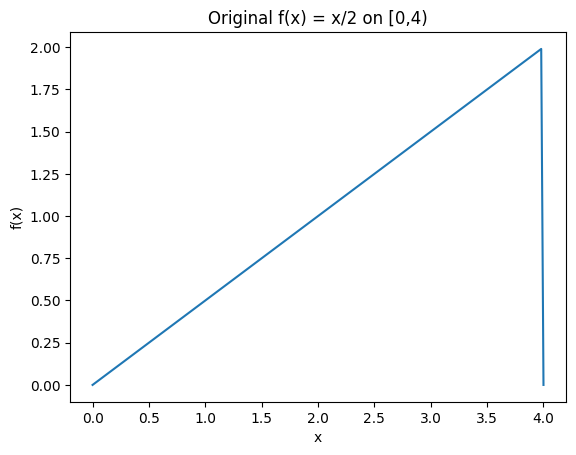

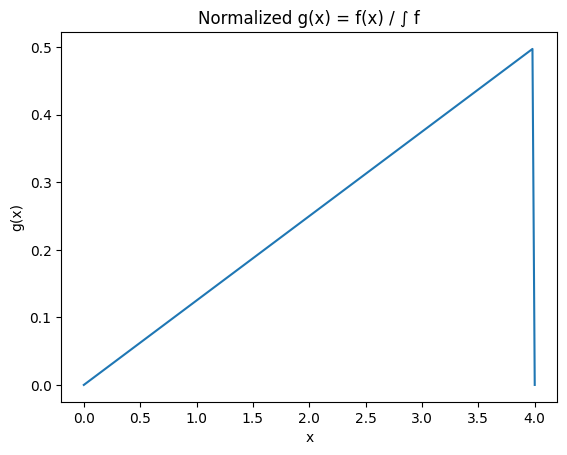

In [4]:
# Check total area of f(x)
total_area = quad(f_pdf, -np.inf, np.inf)[0]
print('Total area under f(x):', total_area)

# Define normalized pdf g(x) = f(x)/total_area
def g_pdf(u):
    return f_pdf(u) / total_area

P_1_2_normalized = quad(g_pdf, 1, 2)[0]
print('P(1 ≤ X ≤ 2) with normalized PDF g:', P_1_2_normalized)

# Optional: visualize original f and normalized g on [0,4]
xs = np.linspace(0, 4, 200)
f_vals = [f_pdf(t) for t in xs]
g_vals = [g_pdf(t) for t in xs]

plt.plot(xs, f_vals)
plt.title('Original f(x) = x/2 on [0,4)')
plt.xlabel('x'); plt.ylabel('f(x)')
plt.show()

plt.plot(xs, g_vals)
plt.title('Normalized g(x) = f(x) / ∫ f')
plt.xlabel('x'); plt.ylabel('g(x)')
plt.show()

### Takeaways (Problem 1)
- Integrate the PDF over the interval to get the probability.
- Always **verify normalization**. If the provided function isn't a valid PDF (area ≠ 1), scale it.
- In this problem, the integral over [1,2] equals **3/4** for the unnormalized function (matching the worked example).

## 📈 Problem 2: Derive the CDF from a PDF
Given the PDF
\[ f(x) = \begin{cases}
  3x^2, & 0 \le x \le 1 \\
  0, & \text{otherwise}
\end{cases} \]
Find the CDF $F(x)=P(X\le x)$ as a **piecewise** function:
- If $x<0$: $F(x)=0$.
- If $0 \le x \le 1$: $F(x)=\int_0^x 3t^2\,dt = x^3$.
- If $x>1$: $F(x)=1$.

In [5]:
# Symbolic derivation with SymPy
x = sp.symbols('x', real=True)
t = sp.symbols('t', real=True)
f2 = sp.Piecewise((3*t**2, (t >= 0) & (t <= 1)), (0, True))

# Define F(x) = ∫_{-∞}^x f(u) du. For this PDF, we can write it piecewise:
F_piece = sp.Piecewise(
    (0, x < 0),
    (sp.integrate(3*t**2, (t, 0, x)), (x >= 0) & (x <= 1)),
    (1, x > 1)
)
sp.simplify(F_piece)

Piecewise((0, x < 0), (x**3, x <= 1), (1, True))

F(-0.5) = 0.0
F(0) = 0.0
F(0.5) = 0.125
F(1) = 1.0
F(1.5) = 1.0


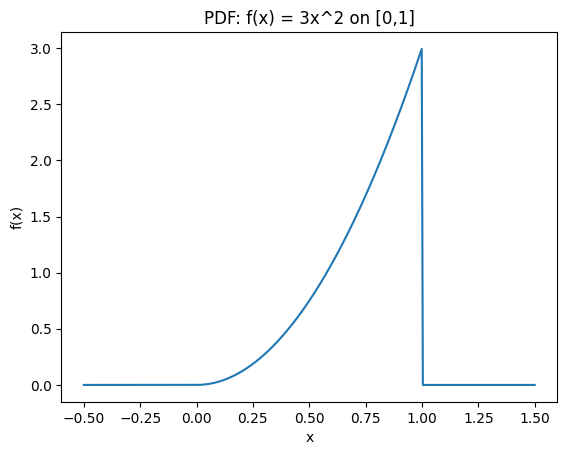

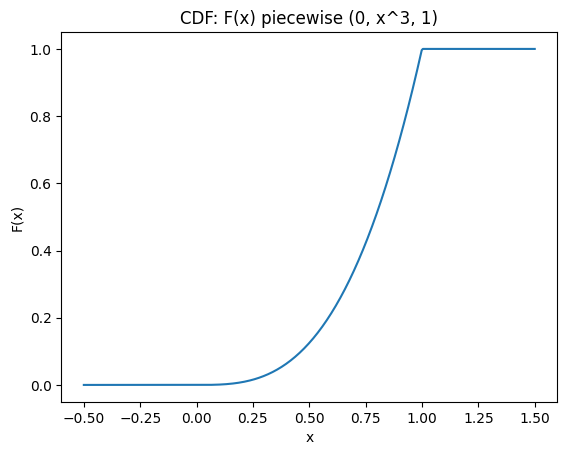

In [6]:
# Turn F(x) and f(x) into numeric callables for plotting/evaluation
F_lambda = sp.lambdify(x, F_piece, 'numpy')
f_lambda = sp.lambdify(x, sp.Piecewise((3*x**2, (x >= 0) & (x <= 1)), (0, True)), 'numpy')

# Evaluate some points
for val in [-0.5, 0, 0.5, 1, 1.5]:
    print(f'F({val}) =', F_lambda(val))

# Plot PDF on [-0.5, 1.5]
xs = np.linspace(-0.5, 1.5, 400)
plt.plot(xs, f_lambda(xs))
plt.title('PDF: f(x) = 3x^2 on [0,1]')
plt.xlabel('x'); plt.ylabel('f(x)')
plt.show()

# Plot CDF on the same domain
plt.plot(xs, F_lambda(xs))
plt.title('CDF: F(x) piecewise (0, x^3, 1)')
plt.xlabel('x'); plt.ylabel('F(x)')
plt.show()

## ✅ Summary
- Use **`quad`** (SciPy) for accurate numeric integration of PDFs over intervals.
- Use **SymPy** to produce **exact integrals** and **piecewise CDFs**.
- Always verify a function is a **valid PDF** (area = 1); if not, **normalize**.
- For piecewise PDFs, build **piecewise CDFs** and check $F(x)$ is 0→1 and non-decreasing.